In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import pandas as pd
plt.style.use('../styles/general.mplstyle')

In [2]:
from sklearn.metrics import mean_squared_error as MSE
from scipy import optimize as scop

In [3]:
from numba import njit


        
@njit
def rush_larsen_easy_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c)
        
@njit
def rush_larsen_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c[i-1])
 

$$ \frac{\partial V_{p}}{\partial t} = \frac{V_{c} - V_{p}}{C_{p}*R_{p}} \\ $$
$$ \frac{\partial V_{m}}{\partial t} = \frac{V_{p} - V_{m}}{C_{m}*R_{s}} - \frac{I_{ion}+I_{leak}}{C_m} \\ $$
$$ \frac{\partial m}{\partial t} = \frac{m_{inf} - m}{\tau_{m}}  \\ $$
$$ \frac{\partial h}{\partial t} = \frac{h_{inf} - h}{\tau_{h}}  \\ $$
$$
I_{m} = C_{m} *\frac{\partial V_{m}}{\partial t} \\
I_{p} = C_{p} *\frac{\partial V_{p}}{\partial t} \\
I_{leak} = g_{leak} * V_{m}
$$

In [54]:

@njit
def euler_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = x[i-1] + (y[i-1] - x[i-1]) * c
        
@njit
def calculate_cicle(t,v_c, v_rev, x):
    c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, r_m, r_p, g_max, g_leak, v_half_m, v_half_h, k_m, k_h = x
    alpha_m = np.zeros_like(t)
    beta_m = np.zeros_like(t)
    alpha_h = np.zeros_like(t)
    beta_h = np.zeros_like(t)
    
    tau_m = np.zeros_like(t)
    tau_h = np.zeros_like(t)
    
    m_inf = np.zeros_like(t)
    h_inf = np.zeros_like(t)
    
    v_p = np.zeros_like(t)
    v_m = np.zeros_like(t)
    
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    
    I_leak = np.zeros_like(t)
    I_Na = np.zeros_like(t)
    
    v_p[0] = -80
    v_m[0] = -80
    m_inf[0] = 0
    h_inf[0] = 1 
    
    n_step = len(t)
    
    dt = t[1] - t[0]
    for i in range(1, n_step):
        v_p[i] = v_c[i-1] + (v_p[i-1] - v_c[i-1])*np.exp(-dt / (r_p * c_p))
        v_m[i] = v_m[i-1] + (v_p[i-1] - v_m[i-1])*dt / (r_m * c_m) - 1e-9*(I_Na[i-1]+I_leak[i-1])*dt/c_m 
        
        alpha_m[i-1]  = a0_m * np.exp(-delta_m * v_m[i-1] / (-s_m)) 
        beta_m[i-1] = b0_m * np.exp((1-delta_m) * v_m[i-1] / (-s_m))
        #print(v)

        alpha_h[i-1]  = a0_h * np.exp(-delta_h * v_m[i-1] / s_h) 
        beta_h[i-1] = b0_h * np.exp((1-delta_h) * v_m[i-1] / s_h)

        tau_m[i-1] = 1 / (beta_m[i-1] + alpha_m[i-1])
        tau_h[i-1] = 1 / (beta_h[i-1] + alpha_h[i-1])

        m_inf[i-1] = 1 / (1 + np.exp((- v_half_m - v_m[i-1]) / k_m))
        h_inf[i-1] = 1 / (1 + np.exp((v_half_h + v_m[i-1]) / k_h))
        #m_inf = 1/(1+beta_m/alpha_m)
        #h_inf = 1/(1+beta_h/alpha_h)


        
        m[i] = m_inf[i-1] + (m[i-1] - m_inf[i-1])*np.exp(-dt/tau_m[i-1])
        h[i] = h_inf[i-1] + (h[i-1] - h_inf[i-1])*np.exp(-dt/tau_h[i-1])
        
        I_leak[i] = g_leak * v_m[i]
        I_Na[i] = g_max * h[i] * (m[i]**3) * (v_m[i] - v_rev)
    
    return m_inf, h_inf, tau_m, tau_h, v_p, v_m, I_leak, I_Na



def calculate_I_out(x, *args):#, s0, c, protocol, ...):

    kwargs = args[-1]
    
    t = kwargs['t']
    v_list = kwargs['v_list']
    k_list = kwargs['k_list']
    
    if kwargs.get('log_scale', False):
        x = np.exp(x)
        assert np.all(x > 0) 
    
    
    c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, r_m, r_p, g_max, g_leak, v_half_m, v_half_h, k_m, k_h = x 

    # constructing v_c - command potential

    count = np.zeros_like(t)
    count[k_list] = 1
    count = np.cumsum(count) 
    
    
    v_c = np.zeros_like(t)
    v_c = v_list[count.astype(int)]
    v_rev =18
    
    I_out = np.zeros_like(t)
    try:
        m_inf, h_inf, tau_m, tau_h, v_p, v_m, I_leak, I_Na = calculate_cicle(t,v_c, v_rev,x)
    except ZeroDivisionError:
        I_out+=1e10
        return I_out
    #I_p = np.zeros_like(t)
    #I_c = np.zeros_like(t)
    I_c = 1e9 * c_m * np.diff(v_m) / dt
    I_p = 1e9 * c_p * np.diff(v_p) / dt
    I_c = np.concatenate((I_c,I_c[-1:]))
    I_p = np.concatenate((I_p,I_p[-1:]))
    
    
    tau_z = 5e-4 # 1e-12 * 5e8
    
    I_in = I_c + I_p + I_leak + I_Na
    
    euler_numba_helper(I_out,I_in,(dt / tau_z))  
 
    if kwargs.get('graph', True):
        #plt.plot(V_m_list, label = 'command')
        
        plt.plot(v_c, label = 'command_prediction')
        plt.plot(v_p, label = 'pipette', ls = '--')
        plt.plot(v_m, label = 'membrane')
        plt.legend()
        
        plt.figure() 
        plt.plot(v_m, m_inf, label = 'm_inf')
        plt.plot(v_m, h_inf, label = 'h_inf')
        plt.legend()
        
        plt.figure() 
        plt.plot(v_m, tau_m, label = 'tau_m')
        plt.plot(v_m, tau_h, label = 'tau_h')
        plt.legend()

        plt.figure()
        plt.plot(I_c, label = 'I_c')
        plt.plot(I_p, label = 'I_p')
        plt.plot(I_leak, label = 'I_leak')
        plt.plot(I_Na, label = 'I_Na')
        plt.legend()
        
        plt.figure()
        plt.plot(I_out, label = 'I_out')
        plt.legend()
        
    return I_out

In [55]:
k_list = np.array([77, 1077, 2077, 4077])
v_list = np.array([-80, -70, -80, -80])
k_all = k_list
v_all = v_list
for l in range(1,20):
    k_all = np.concatenate([k_all, k_list+5000*l])
    v_all = np.concatenate([v_all, v_list+[0,  0, 0, 5*l]])
v_all = np.concatenate([v_all,[-80]])


In [56]:
k_list_1 = np.array([77, 1077, 2077, 4077])
v_list_1 = np.array([-80,-70,-80, -10, -80])

In [57]:
p0 = np.array([6e-16, 6e-12, 2e3,  1.6e3,   0.9,   60,  1e-1,   4e2,    0.3,     3,    8e8,   5e3,  13,   2e-1, 11, 52,0.2,0.3])
#x_true = [6e-15, 12e-12, 5e4,  8e-2,   0.3,   60,  1e-3,   4e2,    0.08,     22,    5e8,   1e6,   5e1,   1e-1]
p0 = np.array([6e-15, 12e-12, 90,  8e1,0.2,   100,    6e-3,   4e3,    0.1,  1,    5e8,   5e3,   5e1,   1e-1,20,30,5,7])
#             C_p     C     a0_m  b0_m  delta_m  s_m   a0_h  b0_h    delta_h      s_h      R    R_p   g_max  g_leak


x_true_log = np.log(p0)

t = np.load('../data/time.npy')

v_list = v_all#np.array([-80, -80, -70, -80, -10, -80])
k_list = k_all#np.array([77, 1077, 2077, 4077]) 
dt = t[1] - t[0]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)#,
              #sample_weights = sample_weight)

#data_1 = calculate_I_out(x_true_log, kwargs) 

data = calculate_I_out(x_true_log, kwargs) 


In [59]:
sample_weight = np.zeros(5000)
sample_weight[:]+= 1
#sample_weight[k_list_1[2]+40:k_list_1[2]+900] += 1
#sample

In [60]:
def loss(x, *args):
    kwargs = args[-1]
    data = args[0]
    sample_weight = kwargs.get('sample_weight', None)
    I_out = calculate_I_out(x, *args)
    
    if np.any(np.isnan(I_out)):
        return np.inf
        
    return MSE(data, I_out, sample_weight=sample_weight)

In [61]:
%%timeit

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
loss(x_true_log, data, kwargs)

1.1 ms ± 75.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
names =  ["C_f","C","a0_m","b0_m","delta_m","s_m","a0_h","b0_h" ,"delta_h","s_h","R"   , "R_f"  , "g_max"  ,"g_leak", "v_half_m", "v_half_h", "k_m", "k_h" ]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
x0 = x_true_log - 0.5
bounds = np.vstack([x_true_log  - 3, x_true_log + 3]).T
loss(x_true_log, data, kwargs)

0.0

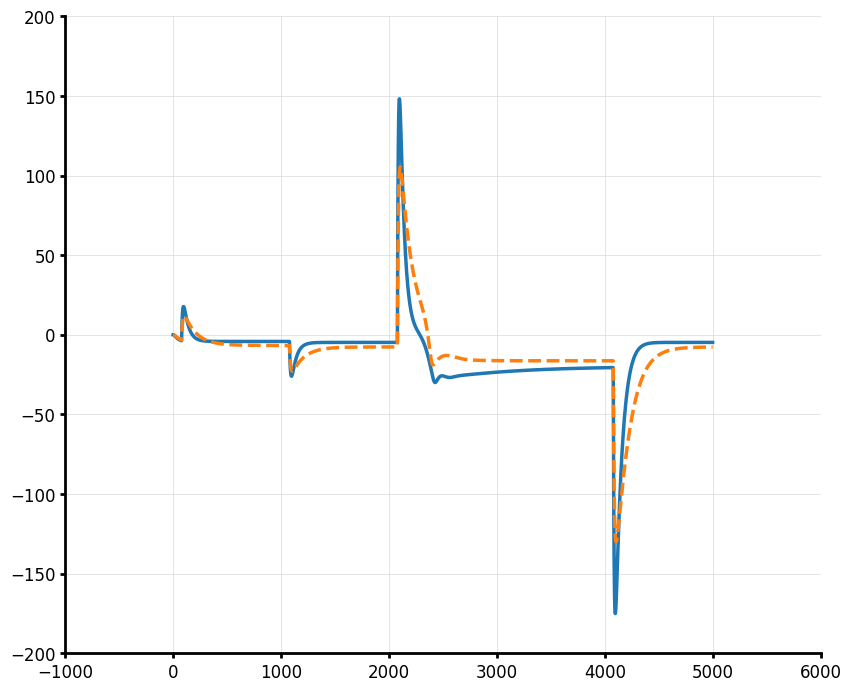

In [63]:
plt.plot(calculate_I_out(x0, kwargs))
plt.plot(data, '--')

### minimize

In [64]:
%%time
res = scop.minimize(loss, x0, bounds=bounds, args=(data, kwargs))

CPU times: user 10.7 s, sys: 3.82 ms, total: 10.7 s
Wall time: 10.7 s


In [65]:
loss(res.x, data, kwargs)

7.083271456355609e-06

In [66]:
x_true_log - res.x

array([ 5.51551008e-02,  8.63471896e-05, -1.54721899e-01,  2.02479983e-01,
        3.74334867e-01,  4.52289581e-02,  3.95280690e-01, -6.21805618e-03,
       -1.23635296e-01,  1.97285852e-02,  1.11232547e-04,  5.00000000e-01,
        3.59313282e-01,  1.14794901e-04, -6.74903522e-04,  9.28402999e-02,
        1.10469202e-03,  3.74107737e-03])

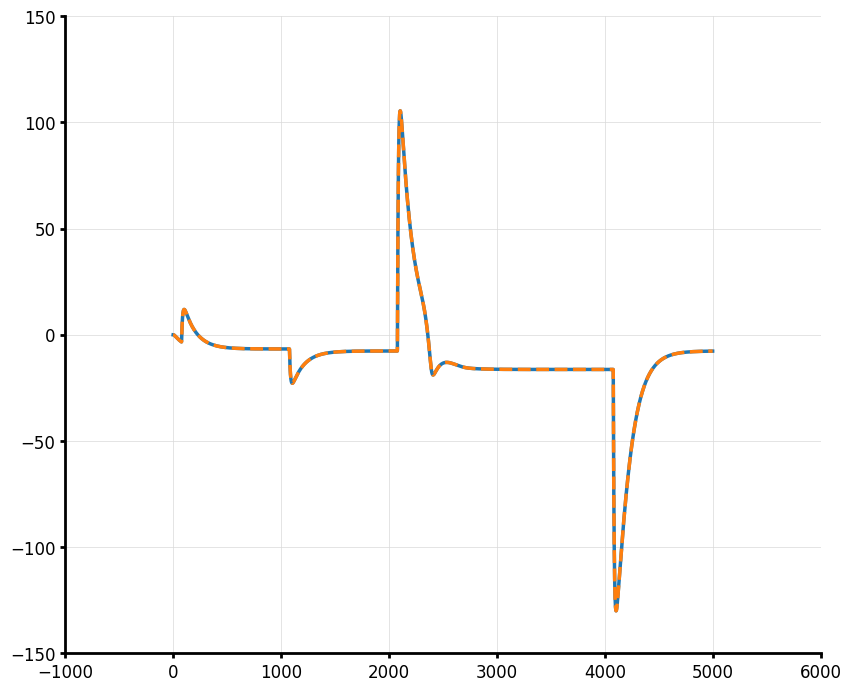

In [67]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '--')

 ### real_data_minimize


In [68]:
real_data = pd.read_csv('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
real_data_small = real_data[14]
#real_data = np.concatenate([real_data[k] for k in range(1,21)])

#sample_weights = np.zeros(5000)
#sample_weights[2210:4000] += 1


#           C_f     C    a0_m   b0_m   delta_m  s_m   a0_h   b0_h  delta_h  s_h    R    R_f  g_max  g_leak v_half_m v_half_h k_m  k_h 
bounds = ([1e-20, 1e-13, 1e-10, 1e-10, 1e-10,  1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e5,  1e3,  1e-5, 1e-5,  1e-4,     1e-4,   1e-4,1e-4],
          [1e-9,  1e-10, 1e8,   1e6,   1,      1e4,   1e8,   1e8,   1,     1e8,   1e15, 1e15, 1e5,  1e5,   100,      100,    1e2, 1e2])
log_bounds = np.vstack([np.log(bounds[0]),np.log(bounds[1])]).T
kwargs_for_count = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)#,
              #sample_weight = sample_weights)


In [69]:
%%time
res = scop.minimize(loss, x_true_log, bounds=log_bounds, args=(real_data_small, kwargs_for_count),method = 'Nelder-Mead',
               options={'maxfev':1e3, 'adaptive':True})

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


CPU times: user 1.26 s, sys: 4.09 ms, total: 1.26 s
Wall time: 1.27 s


In [70]:
loss(res.x, real_data_small, kwargs_for_count)

496.339141001773

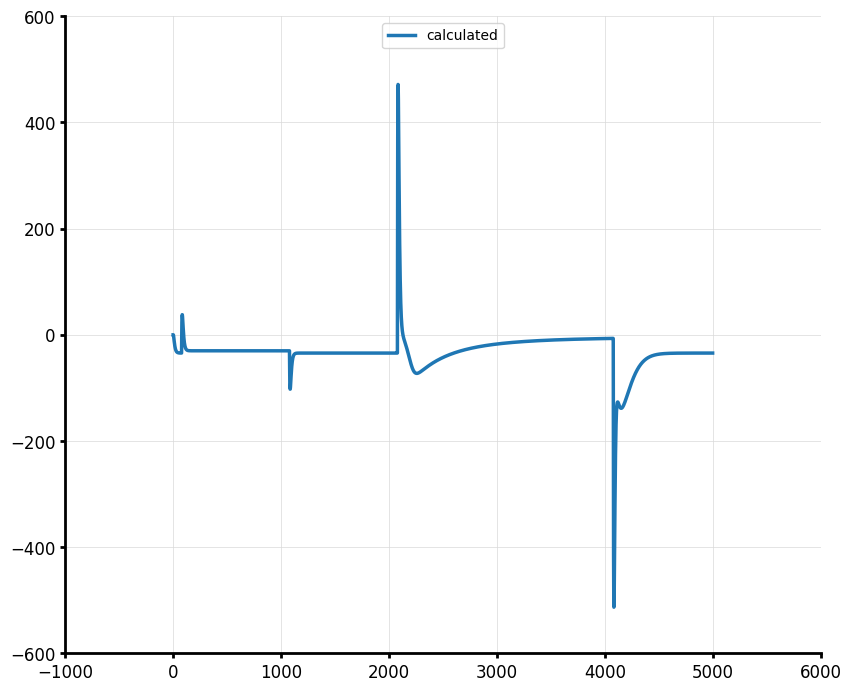

In [71]:
plt.plot(calculate_I_out(res.x, kwargs), label = 'calculated')

plt.legend()
#plt.axvline(2210)
#plt.plot(real_data_small, '--', label = 'real data')

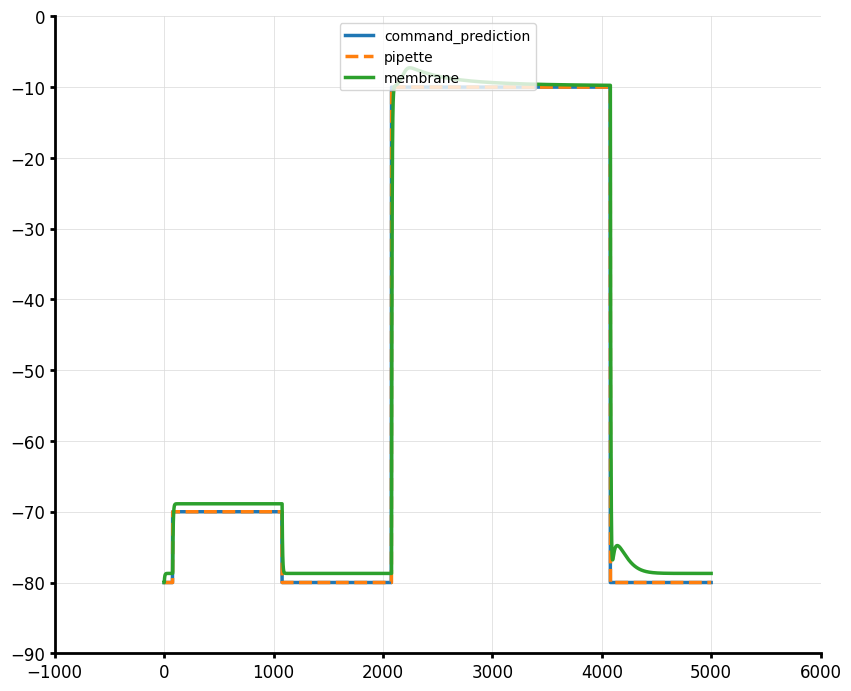

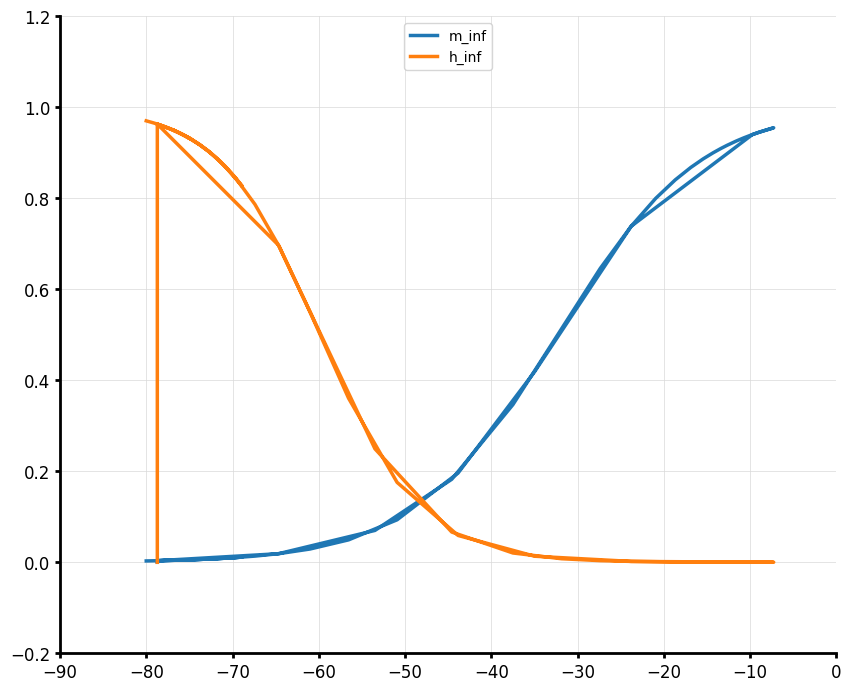

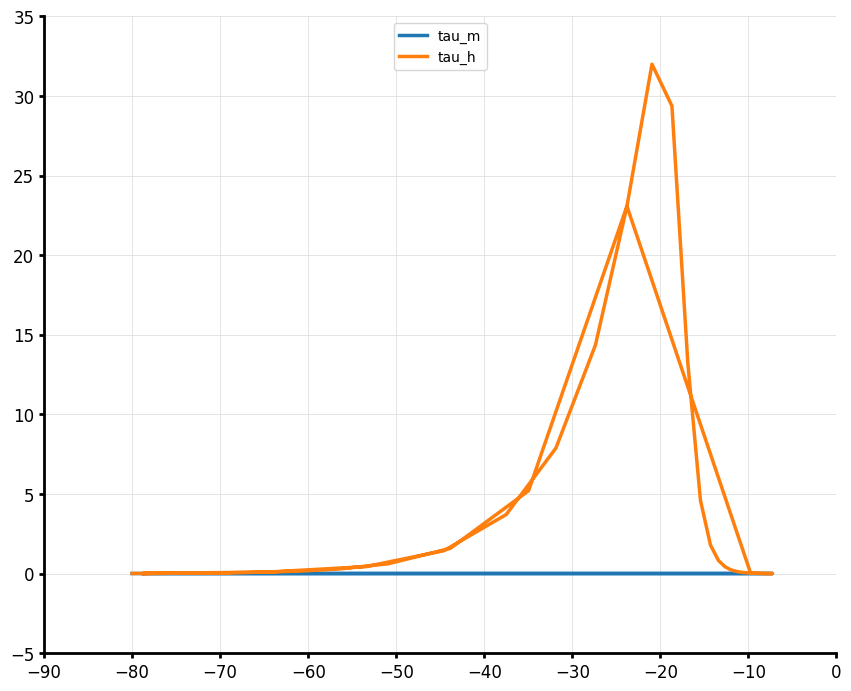

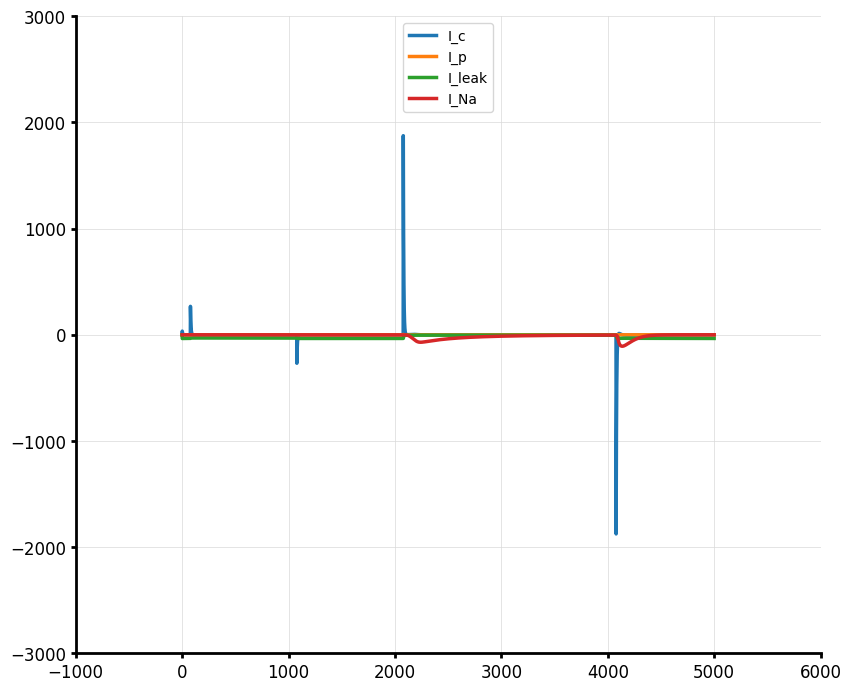

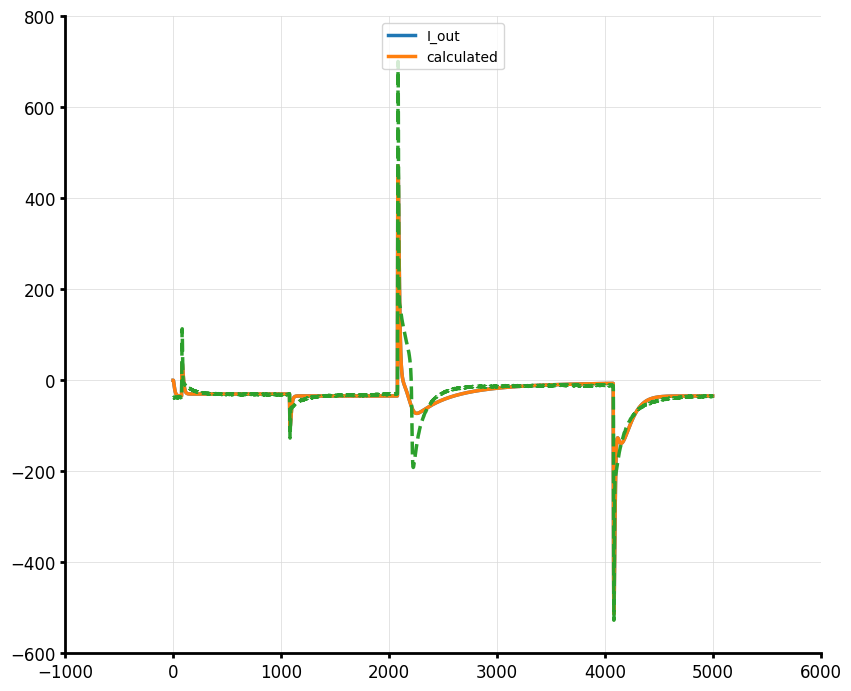

In [72]:
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = True)#,
              #sample_weight = sample_weights)
plt.plot(calculate_I_out(res.x, kwargs), label = 'calculated')

plt.legend()
#plt.axvline(2210)
plt.plot(real_data_small, '--', label = 'real data')

In [73]:
#plt.scatter(names,log_bounds.T[0], marker = '_', s = 500, c = 'k')
#plt.scatter(names,log_bounds.T[1], marker = '_', s = 500, c = 'k')
#plt.scatter(names, res.x)

In [74]:
for k in range(len(res.x)):
    print(names[k], ' = ',np.exp(res.x)[k])

C_f  =  2.6875561604677864e-15
C  =  6.677065521681388e-12
a0_m  =  82.95774157195197
b0_m  =  26.691898591119138
delta_m  =  0.16579956894347253
s_m  =  235.65903892277868
a0_h  =  0.0018025039950562624
b0_h  =  133861.94629709498
delta_h  =  0.133352409210941
s_h  =  0.9989227255424777
R  =  37320630.715220496
R_f  =  2231.9345059140596
g_max  =  36.72369216647971
g_leak  =  0.43710616072345415
v_half_m  =  32.30053539224099
v_half_h  =  59.85685181744355
k_m  =  8.192709560843253
k_h  =  5.778085354257431


### differential_evolution

In [27]:
%%time
res = scop.differential_evolution(loss,
                                  bounds=log_bounds,
                                  args=(real_data_small, kwargs_for_count),
                                  maxiter=10, # I don't want to wait too long
                                  #disp=True,
                                  workers=-1,
                                  seed=42,
                                  )

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:495: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"
<ipython-input-4-88d5f4f14aff>:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-4-88d5f4f14aff>:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-4-88d5f4f14aff>:137: RuntimeWarning: More than 20 figures have been 

Traceback (most recent call last):
  File "/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py", line 308, in differential_evolution
    ret = solver.solve()
  File "/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py", line 759, in solve
    next(self)
  File "/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py", line 1115, in __next__
    trial_energies[feasible] = self._calculate_population_energies(
  File "/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py", line 873, in _calculate_population_energies
    calc_energies = list(self._mapwrapper(self.func,
  File "/home/nik/.local/lib/python3.8/site-packages/scipy/_lib/_util.py", line 423, in __call__
    return self._mapfunc(func, iterable)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 364, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/usr/lib/pyth


KeyboardInterrupt



In [ ]:
loss(res.x, real_data_small, kwargs)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')

### dual_annealing

In [ ]:
%%time
res = scop.dual_annealing(loss, bounds=log_bounds, x0 = x_true_log, args=(real_data_small, kwargs), seed=42)

In [ ]:
res

In [ ]:
loss(res.x, real_data_small, kwargs)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')